# Neural Net Demonstration with PyTorch

## Understanding Artificial Neural Networks

Artificial Neural Networks (ANNs) are computational models inspired by the structure and function of biological neural networks found in the human brain. These algorithms consist of interconnected processing units called neurons or nodes, arranged in layers that work together to learn patterns from data.

A typical neural network architecture includes:
- **Input layer**: Neurons that receive information from dataset features
- **Hidden layers**: Intermediate processing layers that extract increasingly complex patterns
- **Output layer**: Final layer that produces the network's predictions

As data flows through the network, each neuron applies a weighted transformation to its inputs, adds a bias term, and passes the result through an activation function. This activation function introduces non-linearity, enabling the network to model complex relationships that linear models cannot capture.

The learning process occurs through **backpropagation**, where prediction errors are calculated and propagated backwards through the network to adjust the weights and biases. This iterative process continues until the network minimises its prediction errors on the training data.

**Deep Neural Networks (DNNs)** extend this concept by incorporating multiple hidden layers, allowing for hierarchical feature learning. Deep learning has achieved remarkable success in complex, high-dimensional tasks such as image recognition, natural language processing, and medical diagnosis, including melanoma detection and radiological imaging analysis.

## Medical Application Demo

This notebook demonstrates how to use PyTorch for medical diagnosis prediction using neural networks. We'll use the breast cancer dataset to build a binary classification model that predicts breast cancer diagnosis (0 = not diagnosed, 1 = diagnosed) based on cellular features extracted from breast mass images.

## Learning Objectives:
- Understand the fundamentals of neural network architecture
- Set up and verify PyTorch environment
- Load and preprocess medical data for deep learning
- Build a simple neural network for binary classification
- Train and evaluate the model using appropriate classification metrics

## 1. Environment Setup and Imports

First we import all the pacakges and functions we need.

With PyTorch and sklearn there are lots of sub modules, so it is common to import individual functions from these modules rather than the whole package as ab alias, like with numpy, pandas, ect.

In [5]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn for preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# Check PyTorch version and CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.7.1
CUDA available: False
Device: CPU
Using device: cpu


## 2. Load Breast Cancer Dataset

We've already played around and explored the dataset, so we won't have a look at it again. However, one thing we do want to know is the distribution of the class we're prediting on, `diagnosis`.

In [16]:
# Load breast cancer dataset from local CSV file
cancer_data = pd.read_csv('breast_cancer.csv')

# Display Distribution data
print(f"Dataset shape: {cancer_data.shape}")
print(f"\nDiagnosis distribution:")
print(cancer_data['diagnosis'].value_counts())
print(f"\nClass balance:")
print(cancer_data['diagnosis'].value_counts(normalize=True))

Dataset shape: (569, 31)

Diagnosis distribution:
diagnosis
1    357
0    212
Name: count, dtype: int64

Class balance:
diagnosis
1    0.627417
0    0.372583
Name: proportion, dtype: float64


## 3. Data Preprocessing

Preprocessing step is crucial for neural network training. We separate our features (cellular characteristics) from our target variable (diagnosis), split the data into training and testing sets to evaluate model performance, and apply standardisation to normalise all features to have zero mean and unit variance. This standardisation ensures that no single feature dominates the learning process due to its scale. Finally, we convert our data to PyTorch tensors and create DataLoaders that will efficiently batch and shuffle our data during training.

In [7]:
# Separate features and target
X = cancer_data.drop('diagnosis', axis=1).values
y = cancer_data['diagnosis'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardise features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Training set class distribution: {np.bincount(y_train.astype(int))}")
print(f"Test set class distribution: {np.bincount(y_test.astype(int))}")

Training samples: 455
Test samples: 114
Number of features: 30
Training set class distribution: [170 285]
Test set class distribution: [42 72]


**What is a tensor?**

A tensor is a mathematical object that generalises familiar concepts like numbers, vectors, and matrices. Think of it as a container for data that can have different dimensions - a single number (0D), a list of numbers (1D), a table of numbers (2D), or even higher-dimensional arrangements. In machine learning, tensors are fundamental because they provide a unified way to represent and manipulate the complex, multi-dimensional data that neural networks process, from simple input features to the intricate weight matrices that define how networks learn and make predictions.

## 4. Define the Neural Network Model

Create a simple feedforward neural network for breast cancer diagnosis prediction.

**Neural Network Architecture Explanation:**

Our `BreastCancerNet` is a feedforward neural network with four fully connected (linear) layers that progressively reduce the dimensionality: input → 64 → 32 → 16 → 1 neuron. This architecture creates a funnel-like structure that learns to extract increasingly abstract features from the cellular characteristics to predict diagnosis. We use ReLU (Rectified Linear Unit) activation functions between layers to introduce non-linearity, allowing the network to learn complex patterns. Dropout layers (20% probability) are included to prevent overfitting by randomly setting some neurons to zero during training, forcing the network to be more robust and generalisable. The final layer uses a sigmoid activation function to output probabilities between 0 and 1 for binary classification.

In [8]:
class BreastCancerNet(nn.Module):
    def __init__(self, input_dim):
        super(BreastCancerNet, self).__init__()
        
        # Define layers with progressively decreasing dimensions
        self.fc1 = nn.Linear(input_dim, 64)  # First hidden layer
        self.fc2 = nn.Linear(64, 32)         # Second hidden layer  
        self.fc3 = nn.Linear(32, 16)         # Third hidden layer
        self.fc4 = nn.Linear(16, 1)          # Output layer
        
        # Activation and regularisation
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()         # For binary classification
        
    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.fc1(x))  # Apply ReLU activation to first layer
        x = self.dropout(x)         # Apply dropout for regularization
        x = self.relu(self.fc2(x))  # Apply ReLU activation to second layer
        x = self.dropout(x)         # Apply dropout for regularization
        x = self.relu(self.fc3(x))  # Apply ReLU activation to third layer
        x = self.fc4(x)             # Final linear transformation
        x = self.sigmoid(x)         # Sigmoid activation for binary classification
        return x

# Initialise model
input_dim = X_train.shape[1]  # Number of features (30 in our case)
model = BreastCancerNet(input_dim=input_dim).to(device)

# Display model architecture
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

BreastCancerNet(
  (fc1): Linear(in_features=30, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)

Total parameters: 4609


## 5. Training Setup

Configure loss function, optimiser, and training parameters.

**Key Components Explained:**

**BCE (Binary Cross-Entropy):** Our loss function that measures the difference between predicted probabilities and actual binary labels. BCE is ideal for binary classification problems as it penalises confident wrong predictions more heavily and provides smooth gradients for optimisation.

**Adam Optimiser:** An adaptive learning rate optimiser that combines the benefits of momentum and RMSprop. Adam automatically adjusts the learning rate for each parameter individually, making it very effective for training neural networks with minimal hyperparameter tuning.

**Training Functions:** The `train_epoch` function performs forward propagation (calculating predictions), computes the loss, and uses backpropagation to update model weights. The `validate` function evaluates model performance on unseen data without updating weights, helping us monitor for overfitting.

In [9]:
# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 50
train_losses = []
val_losses = []

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

## 6. Train the Model

Train the neural network and monitor performance by calling the previous functions per training epoch.

In [10]:
# Training loop
print("Starting training...")
print("-" * 50)

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("-" * 50)
print("Training completed!")

Starting training...
--------------------------------------------------
Epoch [10/50] - Train Loss: 0.0561, Val Loss: 0.0807
Epoch [20/50] - Train Loss: 0.0350, Val Loss: 0.0841
Epoch [30/50] - Train Loss: 0.0214, Val Loss: 0.0913
Epoch [40/50] - Train Loss: 0.0156, Val Loss: 0.1102
Epoch [50/50] - Train Loss: 0.0206, Val Loss: 0.1380
--------------------------------------------------
Training completed!


## 7. Visualise Training Progress

**What we expect to see:** 
Both training and validation loss should decrease over time, indicating the model is learning. Ideally, both curves should converge to a similar low value. If the training loss continues decreasing while validation loss increases, this indicates overfitting. If both curves plateau at a high value, the model may be underfitting and need more complexity or different hyperparameters.

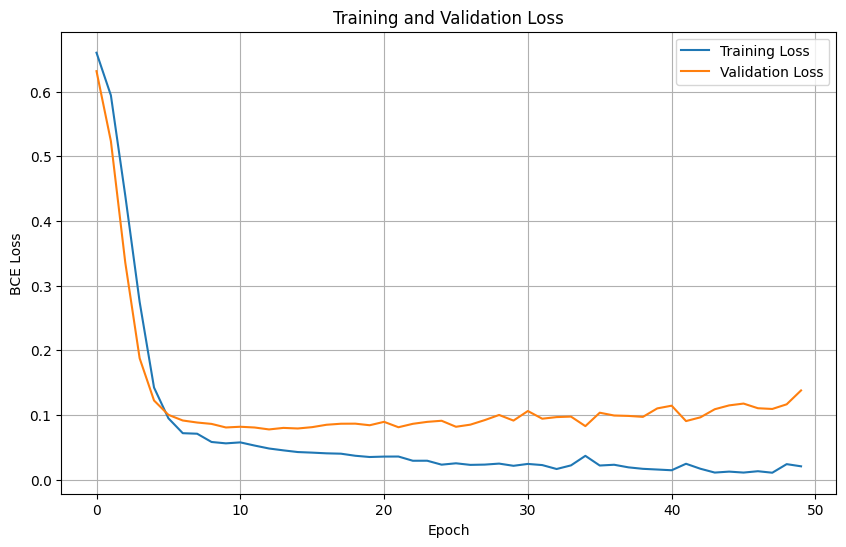

In [11]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 8. Model Evaluation

Evaluate the model's performance on the test set using classification metrics.

**Metrics Explained:**

**Accuracy:** The proportion of correct predictions out of total predictions. For medical diagnosis, high accuracy is important but not the only consideration.

**Precision:** The proportion of positive predictions that were actually correct. In medical context, this represents how often we correctly identify cancer when we predict it.

**Recall (Sensitivity):** The proportion of actual positive cases that were correctly identified. This is crucial in medical diagnosis as we want to catch as many cancer cases as possible.

**F1-Score:** The harmonic mean of precision and recall, providing a balanced measure when both are important.

**ROC Curve and AUC:** The ROC curve plots the true positive rate against the false positive rate at various threshold settings. AUC (Area Under the Curve) provides a single measure of performance across all classification thresholds.

**Confusion Matrix:** Shows the breakdown of correct and incorrect predictions for each class, helping identify if the model has bias towards certain predictions.

Test Set Performance:
Accuracy: 0.9561
Precision: 0.9855
Recall: 0.9444
F1-Score: 0.9645

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.91      0.98      0.94        42
   Malignant       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



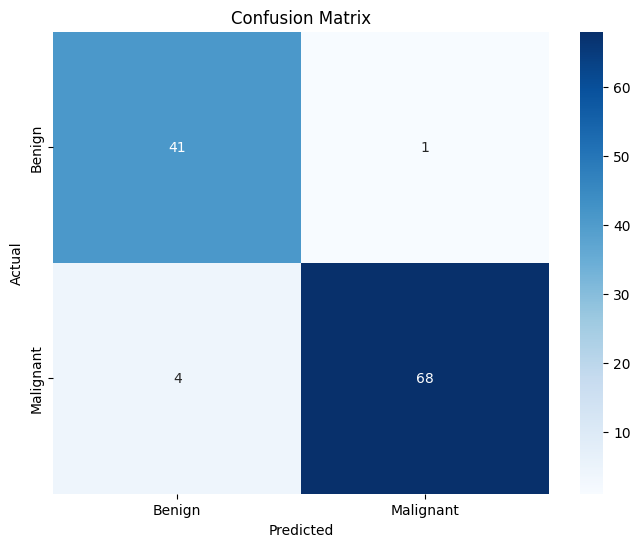

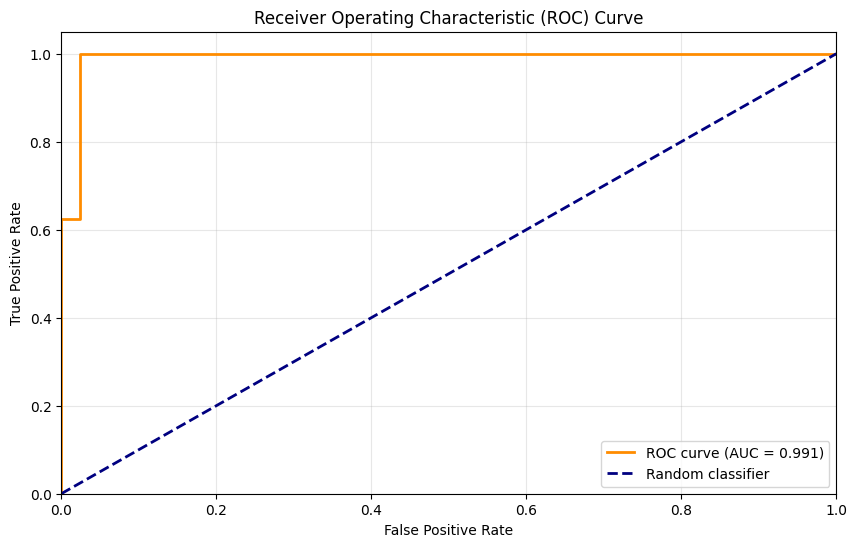


ROC AUC Score: 0.9911


In [12]:
# Make predictions
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    prediction_probs = model(X_test_device).squeeze().cpu().numpy()
    predictions = (prediction_probs > 0.5).astype(int)

# Calculate classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Test Set Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, predictions, target_names=['Benign', 'Malignant']))

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, prediction_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nROC AUC Score: {roc_auc:.4f}")

## 9. Save the Model to the local folder

You would typically save the model to a local file for recall at another time for further training or predictions on new data.

In [13]:
# Save the trained model as a .pth file in the current directory
model_path = 'breast_cancer_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': scaler,
    'input_dim': X_train.shape[1],
    'train_losses': train_losses,
    'val_losses': val_losses
}, model_path)


print(f"Model saved to {model_path}")

Model saved to breast_cancer_model.pth


Load in the model as so:

In [14]:
# load in the models parameters 
checkpoint = torch.load('./breast_cancer_model.pth', weights_only=False)

# Grab the input dimensions and initialise the model
input_dim = checkpoint['input_dim']
model = BreastCancerNet(input_dim=input_dim)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Set to evaluation mode for predictions (it switches off the drop-out layers so all neurons are active)
# If you are training further, forgo this step
model.eval()

# Move to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## 10. Summary and Next Steps

### What we've accomplished:
- ✅ Understood the fundamentals of neural network architecture
- ✅ Set up PyTorch environment
- ✅ Loaded and preprocessed breast cancer diagnosis data
- ✅ Built a simple neural network for binary classification
- ✅ Trained and evaluated the model using appropriate classification metrics
- ✅ Visualised results including ROC curve analysis
- ✅ Saved the model for future use

### Key insights:
- Neural networks can effectively learn complex patterns in medical data
- Proper preprocessing and evaluation metrics are crucial for medical applications
- The ROC curve and AUC provide valuable insights into model performance across different thresholds

### Potential improvements:
- Experiment with different network architectures (more/fewer layers, different sizes)
- Try different optimisation techniques (learning rate scheduling, different optimisers)
- Implement cross-validation for more robust evaluation
- Add feature importance analysis to understand which cellular characteristics are most predictive
- Experiment with different threshold values for classification based on clinical requirements
- Consider ensemble methods to combine multiple models